In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# 1. Télécharger les données historiques d’une commodité
# Par exemple pour le pétrole brut (ticker "CL=F")
ticker = "CL=F"
data = yf.download(ticker, start="2018-06-16", end="2023-09-15", interval="1d")

# Vérifier le début des données
print(data.head())
# Colonnes typiques : ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

# On va travailler avec la colonne "Close"
df = data[["Close"]].dropna()

# 2. Normaliser les valeurs entre 0 et 1
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

# 3. Diviser train / test (par exemple 70 % / 30 %)
split_idx = int(len(df_scaled) * 0.7)
train = df_scaled[:split_idx]
test = df_scaled[split_idx:]

# 4. Créer les séquences (fenêtres glissantes)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size].flatten())
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 30
X_train, y_train = create_sequences(train, window_size)
X_test, y_test = create_sequences(test, window_size)

# 5. Exemple basique : modèle MLP avec scikit-learn (approximation d’un RNN)
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(64, 32),
                   activation='relu',
                   solver='adam',
                   max_iter=200,
                   random_state=42)

mlp.fit(X_train, y_train.ravel())
y_pred_scaled = mlp.predict(X_test).reshape(-1, 1)

# 6. Retransformer à l’échelle originale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)

# 7. Évaluation
def evaluate(y_true, y_pred, name="Model"):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{name} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

evaluate(y_test_inv, y_pred, "MLP (approx)")

# 8. (Optionnel) convertir les données en DataFrame avec les dates
dates_test = df.index[split_idx + window_size : split_idx + window_size + len(y_pred)]
df_results = pd.DataFrame({
    "Date": dates_test,
    "Actual": y_test_inv.flatten(),
    "Predicted": y_pred.flatten()
})
df_results.set_index("Date", inplace=True)
print(df_results.head())


C:\Users\lulul\AppData\Local\Temp\ipykernel_2820\3877966773.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-06-16", end="2023-09-15", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open   Volume
Ticker           CL=F       CL=F       CL=F       CL=F     CL=F
Date                                                           
2018-06-18  65.849998  65.980003  63.590000  64.400002   218933
2018-06-19  65.070000  65.900002  64.389999  65.820000   122646
2018-06-20  66.220001  66.529999  65.010002  65.110001   801625
2018-06-21  65.540001  66.220001  64.339996  65.339996   760719
2018-06-22  68.580002  69.379997  65.709999  65.930000  1136232
MLP (approx) → RMSE: 6.5452, MAE: 4.9049, MAPE: 5.64%
                Actual   Predicted
Date                              
2022-03-30  107.820000  105.016229
2022-03-31  100.279999  109.144995
2022-04-01   99.269997  113.540281
2022-04-04  103.279999  114.138130
2022-04-05  101.959999  117.376429


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# --- 1. Préparer les données PyTorch ---
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.X = torch.tensor(sequences, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Reshape pour LSTM: (seq_len, input_size)
        return self.X[idx].unsqueeze(-1), self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- 2. Définir le modèle LSTM ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # prendre la sortie du dernier pas de temps
        out = self.fc(out)
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 3. Entraîner le modèle ---
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

# --- 4. Prédiction ---
model.eval()
predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        y_pred = model(X_batch)
        predictions.append(y_pred)

y_pred_scaled = torch.cat(predictions, dim=0).numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)

# --- 5. Évaluation ---
evaluate(y_test_inv, y_pred, "LSTM PyTorch")

# --- 6. Résultats dans DataFrame ---
dates_test = df.index[split_idx + window_size : split_idx + window_size + len(y_pred)]
df_results = pd.DataFrame({
    "Date": dates_test,
    "Actual": y_test_inv.flatten(),
    "Predicted": y_pred.flatten()
})
df_results.set_index("Date", inplace=True)
print(df_results.head())


Epoch 10/50, Loss: 0.000572
Epoch 20/50, Loss: 0.000335
Epoch 30/50, Loss: 0.000444
Epoch 40/50, Loss: 0.000144
Epoch 50/50, Loss: 0.000139
LSTM PyTorch → RMSE: 4.4257, MAE: 3.4244, MAPE: 4.01%
                Actual   Predicted
Date                              
2022-03-30  107.820000  111.364708
2022-03-31  100.279999  111.898323
2022-04-01   99.269997  111.304604
2022-04-04  103.279999  109.889732
2022-04-05  101.959999  108.461838


In [4]:
df_results

,Actual,Predicted
Date,,
2022-03-30,107.820000,111.364708
2022-03-31,100.279999,111.898323
2022-04-01,99.269997,111.304604
2022-04-04,103.279999,109.889732
2022-04-05,101.959999,108.461838
...,...,...
2023-09-08,87.510002,87.259628
2023-09-11,87.290001,88.689537
2023-09-12,88.839996,89.852516


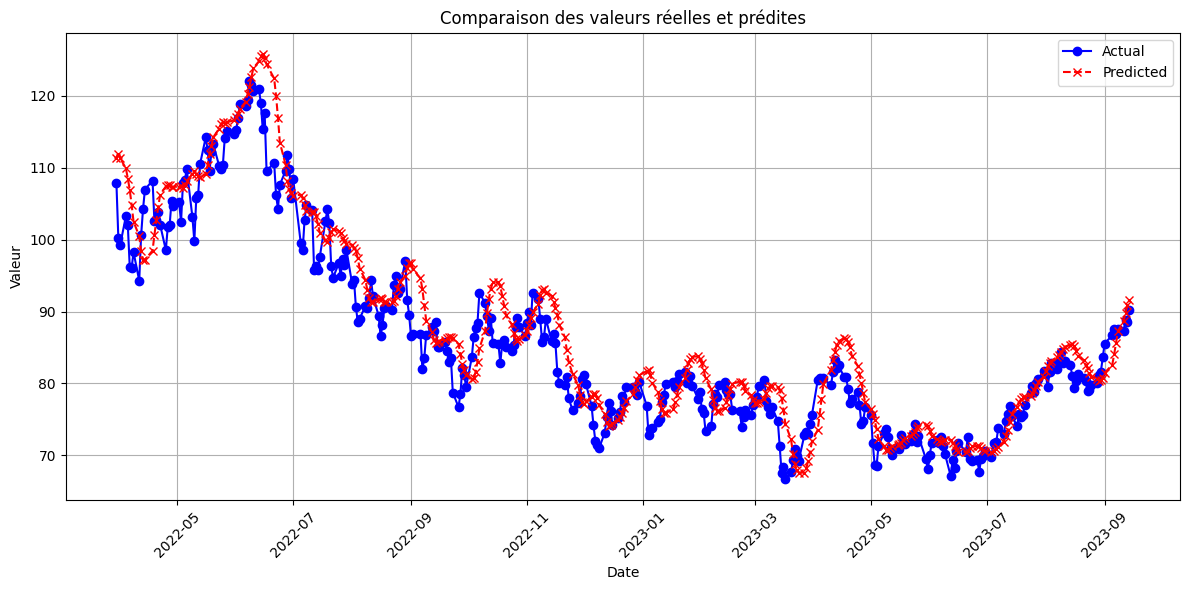

In [5]:
import matplotlib.pyplot as plt

# Assurer que l'index est bien de type datetime
df_results.index = pd.to_datetime(df_results.index)

plt.figure(figsize=(12,6))

# Tracer les valeurs réelles
plt.plot(df_results.index, df_results['Actual'], label='Actual', color='blue', marker='o')

# Tracer les valeurs prédites
plt.plot(df_results.index, df_results['Predicted'], label='Predicted', color='red', linestyle='--', marker='x')

# Titres et légendes
plt.title('Comparaison des valeurs réelles et prédites')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)

# Rotation des dates pour une meilleure lisibilité
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [12]:
# --- Dates des ensembles ---
dates_train = df.index[:split_idx]  # avant le split
dates_test = df.index[split_idx + window_size : split_idx + window_size + len(y_pred)]

print("Train dates:")
print(dates_train[:5], "...", dates_train[-5:])  # aperçu début et fin

print("\nTest dates:")
print(dates_test[:5], "...", dates_test[-5:])  # aperçu début et fin


Train dates:
DatetimeIndex(['2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21',
               '2018-06-22'],
              dtype='datetime64[ns]', name='Date', freq=None) ... DatetimeIndex(['2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11',
               '2022-02-14'],
              dtype='datetime64[ns]', name='Date', freq=None)

Test dates:
DatetimeIndex(['2022-03-30', '2022-03-31', '2022-04-01', '2022-04-04',
               '2022-04-05'],
              dtype='datetime64[ns]', name='Date', freq=None) ... DatetimeIndex(['2023-09-08', '2023-09-11', '2023-09-12', '2023-09-13',
               '2023-09-14'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [13]:
df

Price,Close
Ticker,CL=F
Date,
2018-06-18,65.849998
2018-06-19,65.070000
2018-06-20,66.220001
2018-06-21,65.540001
2018-06-22,68.580002
...,...
2023-09-08,87.510002
2023-09-11,87.290001


In [1]:
# =============================
# 1. Imports
# =============================
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# =============================
# 2. Télécharger les données
# =============================
ticker = "CL=F"  # Pétrole brut
data = yf.download(ticker, start="2018-06-16", end="2023-09-15", interval="1d")

# On garde plusieurs features
df = data[["Open", "High", "Low", "Close", "Volume"]].dropna()

# =============================
# 3. Normalisation
# =============================
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# =============================
# 4. Création des séquences
# =============================
def create_sequences_multistep(data, window_size=30, horizon=7):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i : i + window_size])  # (window, features)
        y.append(data[i + window_size : i + window_size + horizon, 3])  # prédire Close (col 3)
    return np.array(X), np.array(y)

# Fonction pour inverser uniquement la colonne "Close"
def inverse_transform_close(scaled_values, scaler, col_index=3):
    """
    scaled_values : np.array (N, horizon)  → valeurs prédites ou vraies (scaled)
    scaler : MinMaxScaler déjà fit
    col_index : index de la colonne "Close" dans le scaler (par défaut 3)
    """
    # Récupérer les paramètres du scaler
    min_val = scaler.min_[col_index]
    scale_val = scaler.scale_[col_index]
    # Formule inverse : (X - min) / scale → X = X_scaled / scale + min
    return (scaled_values - min_val) / scale_val


window_size = 30
horizon = 7

split_idx = int(len(df_scaled) * 0.7)
train = df_scaled[:split_idx]
test = df_scaled[split_idx:]

X_train, y_train = create_sequences_multistep(train, window_size, horizon)
X_test, y_test = create_sequences_multistep(test, window_size, horizon)

print("X_train:", X_train.shape)  # (nb_samples, window, nb_features)
print("y_train:", y_train.shape)  # (nb_samples, horizon)

# =============================
# 5. Dataset PyTorch
# =============================
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.X = torch.tensor(sequences, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# =============================
# 6. Modèle LSTM
# =============================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=7):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # dernier pas de temps
        out = self.fc(out)    # sortie = horizon (7 valeurs)
        return out

input_size = X_train.shape[2]  # nb features
model = LSTMModel(input_size=input_size, output_size=horizon)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# =============================
# 7. Entraînement
# =============================
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

# =============================
# 8. Prédiction
# =============================
model.eval()
predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        y_pred = model(X_batch)
        predictions.append(y_pred)

y_pred_scaled = torch.cat(predictions, dim=0).numpy()   # (N, 7)
y_pred = inverse_transform_close(y_pred_scaled, scaler, col_index=3)
y_test_inv = inverse_transform_close(y_test, scaler, col_index=3)

# =============================
# 9. Évaluation
# =============================
def evaluate(y_true, y_pred, name="Model"):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{name} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

# Évaluer pour chaque horizon
for i in range(horizon):
    evaluate(y_test_inv[:, i], y_pred[:, i], name=f"LSTM → Jour +{i+1}")

# =============================
# 10. Résultats DataFrame
# =============================
dates_test = df.index[split_idx + window_size : split_idx + window_size + len(y_pred)]
df_results = pd.DataFrame({
    "Date": dates_test,
    **{f"Pred_Day+{i+1}": y_pred[:, i] for i in range(horizon)},
    **{f"Actual_Day+{i+1}": y_test_inv[:, i] for i in range(horizon)}
})
df_results.set_index("Date", inplace=True)
print(df_results.head())


C:\Users\lulul\AppData\Local\Temp\ipykernel_26084\3365026470.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-06-16", end="2023-09-15", interval="1d")
[*********************100%***********************]  1 of 1 completed


X_train: (887, 30, 5)
y_train: (887, 7)
Epoch 5/30, Loss: 0.000658
Epoch 10/30, Loss: 0.000470
Epoch 15/30, Loss: 0.000943
Epoch 20/30, Loss: 0.000565
Epoch 25/30, Loss: 0.001289
Epoch 30/30, Loss: 0.000605
LSTM → Jour +1 → RMSE: 4.9021, MAE: 3.7106, MAPE: 4.15%
LSTM → Jour +2 → RMSE: 5.6041, MAE: 4.1956, MAPE: 4.65%
LSTM → Jour +3 → RMSE: 5.3787, MAE: 4.1569, MAPE: 4.71%
LSTM → Jour +4 → RMSE: 5.6370, MAE: 4.3722, MAPE: 4.97%
LSTM → Jour +5 → RMSE: 5.5193, MAE: 4.3769, MAPE: 5.05%
LSTM → Jour +6 → RMSE: 5.9015, MAE: 4.6257, MAPE: 5.28%
LSTM → Jour +7 → RMSE: 5.9382, MAE: 4.6982, MAPE: 5.39%
            Pred_Day+1  Pred_Day+2  Pred_Day+3  Pred_Day+4  Pred_Day+5  \
Date                                                                     
2022-03-30  101.720638   99.952569  101.495075  101.249510  102.692711   
2022-03-31  101.450177   99.774942  101.268348  101.030736  102.418106   
2022-04-01  100.860725   99.273438  100.644711  100.510414  101.704300   
2022-04-04   99.744979   98.354

In [2]:
df_results.head()

,Pred_Day+1,Pred_Day+2,Pred_Day+3,Pred_Day+4,Pred_Day+5,Pred_Day+6,Pred_Day+7,Actual_Day+1,Actual_Day+2,Actual_Day+3,Actual_Day+4,Actual_Day+5,Actual_Day+6,Actual_Day+7
Date,,,,,,,,,,,,,,
2022-03-30,101.720638,99.952569,101.495075,101.249510,102.692711,101.334612,101.860483,107.820000,100.279999,99.269997,103.279999,101.959999,96.230003,96.029999
2022-03-31,101.450177,99.774942,101.268348,101.030736,102.418106,101.068518,101.621698,100.279999,99.269997,103.279999,101.959999,96.230003,96.029999,98.260002
2022-04-01,100.860725,99.273438,100.644711,100.510414,101.704300,100.437995,100.997186,99.269997,103.279999,101.959999,96.230003,96.029999,98.260002,94.290001
2022-04-04,99.744979,98.354291,99.500020,99.512963,100.415138,99.264707,99.860861,103.279999,101.959999,96.230003,96.029999,98.260002,94.290001,100.599998
2022-04-05,98.621068,97.424066,98.363311,98.464298,99.180297,98.092630,98.742874,101.959999,96.230003,96.029999,98.260002,94.290001,100.599998,104.250000


In [21]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]

In [23]:
df

,Open_CL=F,High_CL=F,Low_CL=F,Close_CL=F,Volume_CL=F
Date,,,,,
2018-06-18,64.400002,65.980003,63.590000,65.849998,218933
2018-06-19,65.820000,65.900002,64.389999,65.070000,122646
2018-06-20,65.110001,66.529999,65.010002,66.220001,801625
2018-06-21,65.339996,66.220001,64.339996,65.540001,760719
2018-06-22,65.930000,69.379997,65.709999,68.580002,1136232
...,...,...,...,...,...
2023-09-08,86.779999,87.949997,86.150002,87.510002,294437
2023-09-11,87.400002,88.150002,86.709999,87.290001,292388
2023-09-12,87.269997,89.370003,87.220001,88.839996,341137


In [25]:
# S'assurer que les index sont bien de type datetime
df_results.index = pd.to_datetime(df_results.index)
df.index = pd.to_datetime(df.index)

# Fusion sur la date
df_merged = df_results.merge(df[["Close_CL=F"]], left_index=True, right_index=True, how="inner")

# Renommer la colonne Close pour plus de clarté
df_merged.rename(columns={"Close_CL=F": "Real_Close"}, inplace=True)



In [26]:
df_results=df_merged

In [32]:
import numpy as np

# Liste des colonnes de prédiction
pred_cols = [f"Pred_Day+{i}" for i in range(1, 8)]

# Moyenne des 7 jours
df_results["Pred_Mean"] = df_results[pred_cols].mean(axis=1)

# Supprimer la première ligne qui a NaN à cause du shift
df_results = df_results.dropna(subset=["Real_Close"])

# Seuil pour éviter les petits écarts (optionnel)
threshold = 0.5 / 100  # 0.5% de variation minimum

# Calcul du ratio
ratio = (df_results["Pred_Mean"] - df_results["Real_Close"]) / df_results["Real_Close"]

# Création du Signal
df_results["Signal"] = np.where(ratio > threshold, 1,
                        np.where(ratio < -threshold, -1, 0))


C:\Users\lulul\AppData\Local\Temp\ipykernel_26084\2290678355.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results["Pred_Mean"] = df_results[pred_cols].mean(axis=1)


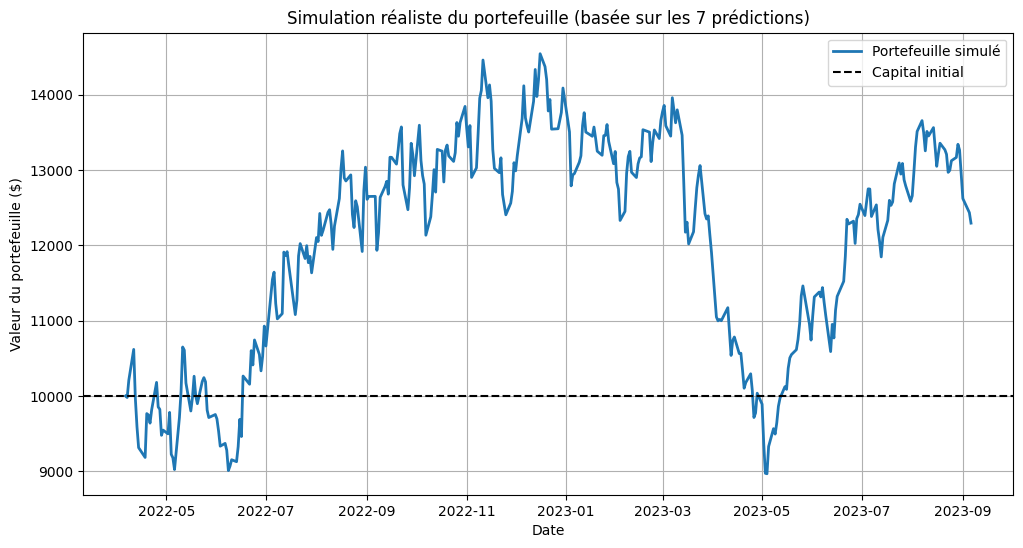


💰 Valeur finale du portefeuille : 12,293.72 $
📈 Performance totale : +22.94 %


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

capital_initial = 10000
cash = capital_initial
positions = 0
portfolio_values = []
last_signal = 0  # pour éviter les achats répétés

for i in range(len(df_results)):
    price_today = df_results["Real_Close"].iloc[i]
    signal = df_results["Signal"].iloc[i]

    # Si signal change (nouvelle décision)
    if signal != last_signal and signal!=0:
        # Fermer la position précédente
        cash += positions * price_today
        positions = 0

        # Ouvrir une nouvelle position si besoin
        if signal == 1 and positions == 0:  # Achat (long)
            positions = cash // price_today
            cash -= positions * price_today

        elif signal == -1 and positions == 0:  # Short (vendre à découvert)
            positions = - (cash // price_today)
            cash += abs(positions) * price_today  # on gagne du cash en shortant

        last_signal = signal

    # Valeur totale du portefeuille à ce moment
    total_value = cash + positions * price_today
    portfolio_values.append(total_value)

# Enregistrer la valeur du portefeuille
df_results["Portfolio_$"] = portfolio_values

# =============================
# Graphique
# =============================
plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results["Portfolio_$"], label="Portefeuille simulé", linewidth=2)
plt.axhline(capital_initial, color="black", linestyle="--", label="Capital initial")
plt.title("Simulation réaliste du portefeuille (basée sur les 7 prédictions)")
plt.xlabel("Date")
plt.ylabel("Valeur du portefeuille ($)")
plt.legend()
plt.grid(True)
plt.show()

# =============================
# Résumé final
# =============================
final_value = df_results["Portfolio_$"].iloc[-1]
performance = (final_value - capital_initial) / capital_initial * 100

print(f"\n💰 Valeur finale du portefeuille : {final_value:,.2f} $")
print(f"📈 Performance totale : {performance:+.2f} %")


In [34]:
df_results["Signal"]

Date
2022-04-06    1
2022-04-07    0
2022-04-08   -1
2022-04-11    0
2022-04-12   -1
             ..
2023-08-30   -1
2023-08-31   -1
2023-09-01   -1
2023-09-05   -1
2023-09-06   -1
Name: Signal, Length: 356, dtype: int64